In [25]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization
import function.DataFunction
import function.visualise
import joblib

In [2]:
path =  'C://python//train//'
fallPath = path + 'fall_csv_test//'
normalPath = path + 'normal_csv_test//'

In [3]:
dtf = function.DataFunction.DataFunction()
vi = function.visualise.Visualise()

In [4]:
label = dtf.labelSet("addframe", fallPath, normalPath)

In [5]:
rawFallData = pd.concat([pd.read_csv(fallPath + file) for file in os.listdir(fallPath)])
rawNormalData = pd.concat([pd.read_csv(normalPath + file) for file in os.listdir(normalPath)]) 

In [6]:
data = np.concatenate((rawFallData, rawNormalData), axis=0)

In [7]:
indices = np.arange(label.shape[0])

In [8]:
np.random.shuffle(indices)

In [9]:
data, label = data[indices], label[indices]

In [10]:
data.shape, label.shape

((8853, 81), (8853,))

In [11]:
data, label = dtf.balanceTrainData(data, label)

In [12]:
x_train, x_test, x_val, y_train, y_test, y_val = dtf.splitData(data, label)

In [13]:
def model_grid():
    param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
    return grid

In [14]:
model = model_grid()
model.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [15]:
def validate(x_val, y_val, model):
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    for score in scoring:
        scores = cross_val_score(model, x_val, y_val, cv=10, scoring=score)
        print(score, scores.mean())

In [16]:
validate(x_val, y_val, model.best_estimator_)

accuracy 0.9711948381149902
precision_macro 0.9722734601629022
recall_macro 0.9711803145963452
f1_macro 0.9711765850949761


In [17]:
y_pred = model.predict(x_test)

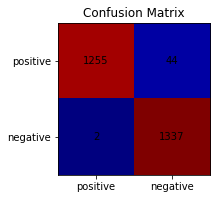

In [18]:
vi.conf_mat(y_test, y_pred)

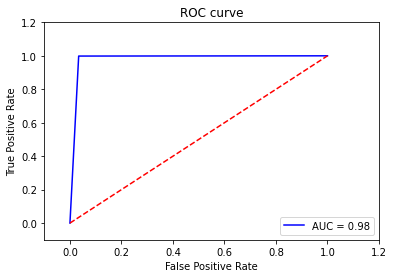

In [19]:
vi.show_roc(y_test, y_pred)

In [20]:
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      0.97      0.98      1299
           1       0.97      1.00      0.98      1339

    accuracy                           0.98      2638
   macro avg       0.98      0.98      0.98      2638
weighted avg       0.98      0.98      0.98      2638



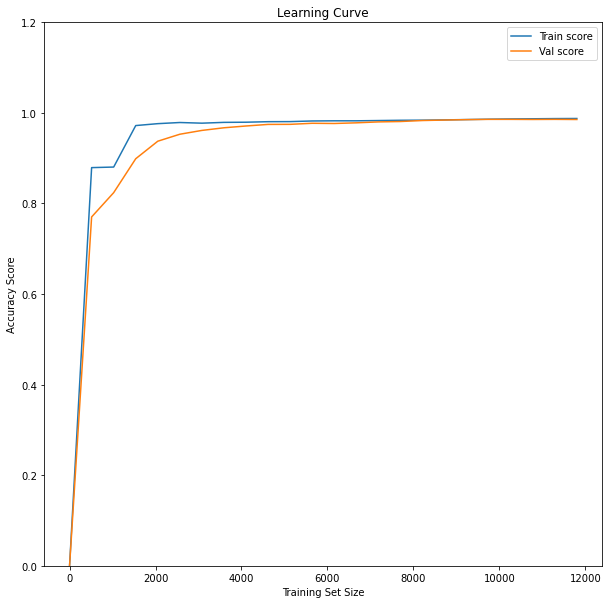

In [21]:
vi.learning_curve_plot(data, label, model.best_estimator_)

In [30]:
joblib.dump(model.best_estimator_, path + 'model_final//model_reduced.sav')

['C://python//train//model_final//model_reduced.sav']

In [22]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [23]:
problem = SVMFeatureSelection(data, label)
task = Task(problem, max_iters=20)
algorithm = ParticleSwarmOptimization(population_size=40, group_size=20)
best_features, best_fitness = algorithm.run(task)

In [27]:
selected_features = best_features >= 0.5

In [28]:
selected_features

array([False, False, False, False, False, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
        True, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False, False,  True, False,  True, False, False,  True,
       False, False,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False,  True, False,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False])

In [29]:
modelPSO = model_grid()
modelPSO.fit(x_train[:,selected_features], y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [31]:
validate(x_val[:,selected_features], y_val, modelPSO.best_estimator_)

accuracy 0.9435173983177785
precision_macro 0.9456691912930614
recall_macro 0.9434969928290539
f1_macro 0.9434402940227586


In [32]:
y_pred = modelPSO.predict(x_test[:,selected_features])
vi.report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       1.00      0.95      0.97      1299
           1       0.95      1.00      0.98      1339

    accuracy                           0.97      2638
   macro avg       0.98      0.97      0.97      2638
weighted avg       0.98      0.97      0.97      2638



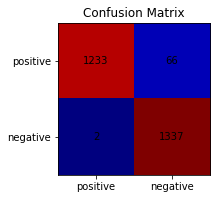

In [33]:
vi.conf_mat(y_test, y_pred)

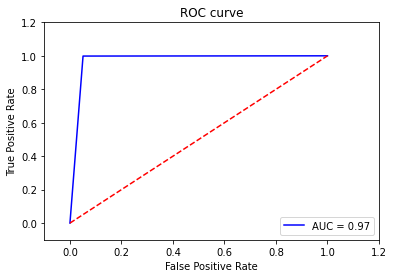

In [34]:
vi.show_roc(y_test, y_pred)

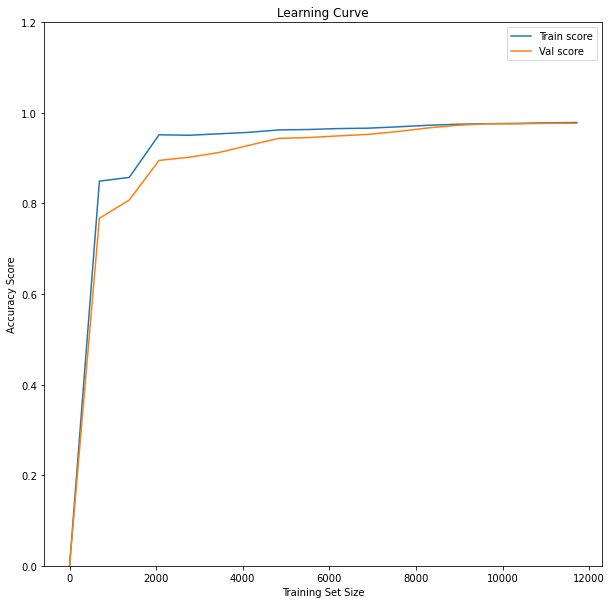

In [37]:
vi.learning_curve_plot(data[:,selected_features], label, modelPSO.best_estimator_)

In [38]:
joblib.dump(modelPSO.best_estimator_, path + 'model_final//model_pso_2.sav')

['C://python//train//model_final//model_pso_2.sav']